In [64]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torch.optim import SGD

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import beta

In [65]:
INPUT_SIZE = 784
NUM_LAYERS = 2
NUM_HIDDEN_UNITS = 64
OUTPUT_SIZE = 10

NUM_EPOCHS = 10
BATCH_SIZE = 500
LEARNING_RATE = 0.1
MOMENTUM = 0.9

NUM_UNDERLYING_DISTRIBUTION = 30000

In [66]:
DATASET = torchvision.datasets.MNIST(root='../data', train=True, transform=transforms.ToTensor(), download=True)

INDEX_UNDERLYING=list(range(NUM_UNDERLYING_DISTRIBUTION))
SUBSET_UNDERLYING=Subset(DATASET, INDEX_UNDERLYING)
LOADER_UNDERLYING=DataLoader(dataset=SUBSET_UNDERLYING, batch_size=BATCH_SIZE, shuffle=False)

In [67]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, num_layers, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.hidden = nn.ModuleList()
        self.input_layer = nn.Linear(input_size, hidden_size)
        for k in range(num_layers-1):
            self.hidden.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x=self.input_layer(x)
        x=x.relu()
        for layer in self.hidden:
            x=layer(x)
            x=x.relu()
        x=self.output_layer(x)
        return x
    
def ReLU_glorot_init(model):
    torch.manual_seed(1)
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

In [68]:
def get_bound(num_samples, eta, zeta, gammas, alpha, delta):
    index_sample=np.random.choice(INDEX_UNDERLYING, num_samples, replace=False)
    index_other, index_approx=train_test_split(index_sample, test_size=eta)
    index_train, index_empirical_error=train_test_split(index_other, test_size=zeta)
    index_train_full, index_empirical_error_full=train_test_split(index_sample, test_size=zeta)

    num_approx=len(index_approx)
    num_empirical_error=len(index_empirical_error)
    num_empirical_error_full=len(index_empirical_error_full)
    num_train=len(index_train)
    num_train_full=len(index_train_full)
    
    subset_train=Subset(SUBSET_UNDERLYING, index_train)
    subset_train_full=Subset(SUBSET_UNDERLYING, index_train_full)
    subset_empirical_error=Subset(SUBSET_UNDERLYING, index_empirical_error)
    subset_empirical_error_full=Subset(SUBSET_UNDERLYING, index_empirical_error_full)

    loader_train = DataLoader(dataset=subset_train, batch_size=BATCH_SIZE, shuffle=True)
    loader_train_full = DataLoader(dataset=subset_train_full, batch_size=BATCH_SIZE, shuffle=True)
    loader_empirical_error = DataLoader(dataset=subset_empirical_error, batch_size=BATCH_SIZE, shuffle=False)
    loader_empirical_error_full = DataLoader(dataset=subset_empirical_error_full, batch_size=BATCH_SIZE, shuffle=False)

    model_region = NeuralNet(INPUT_SIZE, NUM_LAYERS, NUM_HIDDEN_UNITS, OUTPUT_SIZE)
    model_point = NeuralNet(INPUT_SIZE, NUM_LAYERS, NUM_HIDDEN_UNITS, OUTPUT_SIZE)
    ReLU_glorot_init(model_region)
    ReLU_glorot_init(model_point)

    criterion = nn.CrossEntropyLoss()
    optimizer_region = SGD(model_region.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    optimizer_point = SGD(model_point.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

    for epoch in range(NUM_EPOCHS):
        for images, labels in loader_train:
            images = images.reshape(-1, INPUT_SIZE)
            outputs = model_region(images)
            loss = criterion(outputs, labels)
            optimizer_region.zero_grad()
            loss.backward()
            optimizer_region.step()
        #print('Epoch {}: Loss {:.3f}'.format(epoch+1,loss.item()))

    for epoch in range(NUM_EPOCHS):
        for images, labels in loader_train_full:
            images = images.reshape(-1, INPUT_SIZE)
            outputs = model_point(images)
            loss = criterion(outputs, labels)
            optimizer_point.zero_grad()
            loss.backward()
            optimizer_point.step()
        #print('Epoch {}: Loss {:.3f}'.format(epoch+1,loss.item()))

    empirical_accuracy=0
    with torch.no_grad():
        for image, label in loader_empirical_error:
            image = image.reshape(-1, INPUT_SIZE)
            output = model_region(image)
            predictions=output.max(1)[1]
            empirical_accuracy+=sum((predictions==label).tolist())
    empirical_accuracy/=num_empirical_error

    empirical_accuracy_full=0
    with torch.no_grad():
        for image, label in loader_empirical_error_full:
            image = image.reshape(-1, INPUT_SIZE)
            output = model_point(image)
            predictions=output.max(1)[1]
            empirical_accuracy_full+=sum((predictions==label).tolist())
    empirical_accuracy_full/=num_empirical_error_full

    true_accuracy_region=0
    correct_bools=[]
    with torch.no_grad():
        for image, label in LOADER_UNDERLYING:
            image = image.reshape(-1, INPUT_SIZE)
            output = model_region(image)
            predictions=output.max(1)[1]
            correct_bools+=(predictions==label).tolist()
            true_accuracy_region+=sum((predictions==label).tolist())
    true_accuracy_region/=NUM_UNDERLYING_DISTRIBUTION

    true_accuracy_point=0
    with torch.no_grad():
        for image, label in LOADER_UNDERLYING:
            image = image.reshape(-1, INPUT_SIZE)
            output = model_point(image)
            predictions=output.max(1)[1]
            true_accuracy_point+=sum((predictions==label).tolist())
    true_accuracy_point/=NUM_UNDERLYING_DISTRIBUTION

    index_verifiable=[]
    for k,correct in enumerate(correct_bools):
        if correct:
            index_verifiable.append(k)
    bounds_region=np.zeros_like(gammas)
    p_Ls=[]
    for k,gamma in enumerate(gammas):

        prop_to_sample=min(1,gamma/true_accuracy_region)
        Delta=train_test_split(index_verifiable, test_size=prop_to_sample)[1]

        p_hat=0
        for ind in index_approx:
            if ind in Delta:
                p_hat+=1
        p_hat/=num_approx
        p_Delta=len(Delta)/NUM_UNDERLYING_DISTRIBUTION
        p_L=beta.ppf(alpha,int(num_approx*p_hat),int(num_approx-num_approx*p_hat+1))
        p_Ls.append(p_L)
        log_component = np.log((1-p_L+np.sqrt((1-p_L)**2+4*delta**(1/num_empirical_error)*p_L))/(2*delta**(1/num_empirical_error)))
        bound_region=(1-empirical_accuracy)+np.sqrt(log_component/2)
        bounds_region[k]=bound_region
    bound_point=(1-empirical_accuracy_full)+np.sqrt(np.log(1/delta)/(2*num_empirical_error_full))

    return bound_point-(1-true_accuracy_point), bounds_region-np.ones_like(bounds_region)*(1-true_accuracy_region), p_Ls

In [76]:
ZETA=0.3
GAMMA=np.linspace(0.1,0.9,9)
ALPHA=0.025
DELTA=0.025

SAMPLE_SIZE=5000
NUM_ITERATIONS=20

tightness_points=[]
tightness_regions=[]
p_lowerbounds=[]


for j in range(NUM_ITERATIONS):
    tightness_point, tightness_region, p_lowerbound = get_bound(SAMPLE_SIZE,0.1,ZETA,GAMMA,ALPHA,DELTA)
    tightness_points.append(tightness_point)
    tightness_regions+=list(tightness_region)
    p_lowerbounds+=p_lowerbound
    print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [104]:
num_gaps=12
partition_points=np.linspace(0,1,num_gaps+1)
partition_gap=partition_points[1]
partition_data=[[] for n in range(num_gaps)]
for i,p_L in enumerate(p_lowerbounds):
    partition_data[int(p_L//partition_gap)].append(tightness_regions[i])
partition_data_avg=[]
for k,gap_data in enumerate(partition_data):
    if len(gap_data)!=0:
        partition_data_avg.append(sum(gap_data)/len(gap_data))
    else:
        partition_data_avg.append(0)
counter_global=0
while 0 in partition_data_avg:
    if partition_data_avg[counter_global]==0:
        fixed=False
        counter_local=counter_global-1
        while counter_local>0:
            if partition_data_avg[counter_local]==0:
                counter_local-=1
            else:
                partition_data_avg[counter_global]=partition_data_avg[counter_local]
                fixed=True
                break
        if fixed==False and partition_data_avg[counter_global+1]!=0:
            for n in range(counter_global+1):
                partition_data_avg[n]=partition_data_avg[counter_global+1]
    counter_global+=1
    counter_global=counter_global%num_gaps

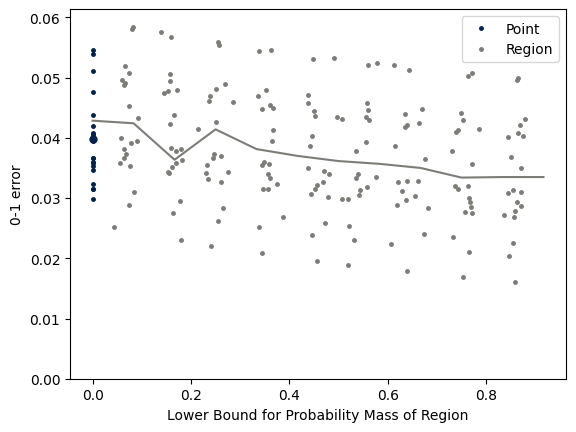

In [107]:
colors = plt.cm.cividis(np.linspace(0, 1, 3))
avg_tightness_point=sum(tightness_points)/len(tightness_points)
plt.plot(0,avg_tightness_point,'o',markersize=5, c=colors[0])
plt.plot(np.zeros_like(tightness_points),tightness_points,'o',label='Point',markersize=2.5, c=colors[0])
plt.plot(partition_points[:-1], partition_data_avg, c=colors[1],markersize=2.5)
plt.plot(p_lowerbounds, tightness_regions,'o', label='Region', c=colors[1],markersize=2.5)
plt.xlabel('Lower Bound for Probability Mass of Region')
plt.ylabel('0-1 error')
plt.ylim(0,1.05*max(average_tightness_point,max(tightness_regions)))
plt.legend()
plt.savefig('plots/MNIST_Bound_Tightness.png')